<a href="https://colab.research.google.com/github/XuanCheng33/Colab-Projects/blob/main/%E2%80%9CAmazon_prime_project_ipynb%E2%80%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prime Video view time exploration and prediction

In this project, I build a numeric prediction model to predict the cvt_per_day based on the information in the Amazon prime video dataset. Cvt_per_day is a measure on how much a movie is consumed by the audiences per day. Higher number means the movie is more popular on the platform.


## Contents

* [Part 1: Load Data and Packages](#Part-1:-Load-Data-and-Packages)
* [Part 2: Exploratory Data Analysis](#Part-2:-Exploratory-Data-Analysis)
* [Part 3: Feature Preprocessing](#Part-3:-Feature-Preprocessing)
* [Part 4: Model Training](#Part-4:-Model-Training)
* [Part 5: Model Evaluation](#Part-5:-Model-Evaluation)

# Part 0: Setup Google Drive Environment

In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
file = drive.CreateFile({'id':'1jAJrgAxsyS-YEl9sJT46DE3_BeStmdFS'}) # https://drive.google.com/file/d/1jAJrgAxsyS-YEl9sJT46DE3_BeStmdFS/view?usp=sharing
file.GetContentFile('TVdata.txt')  

# Part 1 Load Data and Packages


In [ ]:
#import libraries
import numpy as np
import pandas as pd
import sklearn as sl
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)


In [ ]:
TV=pd.read_table('TVdata.txt',header=0,sep=',',lineterminator='\n')
print(TV.head())

   video_id  cvt_per_day  weighted_categorical_position  \
0    385504   307127.606                              1   
1    300175   270338.426                              1   
2    361899   256165.867                              1   
3    308314   196622.721                              3   
4    307201   159841.652                              1   

   weighted_horizontal_poition  import_id  release_year  \
0                            3  lionsgate          2013   
1                            3  lionsgate          2013   
2                            3      other          2012   
3                            4  lionsgate          2008   
4                            3  lionsgate          2013   

                                          genres  imdb_votes    budget  \
0                          Action,Thriller,Drama       69614  15000000   
1                          Comedy,Crime,Thriller       46705  15000000   
2                                    Crime,Drama      197596  260000

# Part 2: Exploratory Data Analysis

## 2.1 Exclude erroneous data

Each video should only appear once in the list, duplicated video will be removed.

In [ ]:
if TV['video_id'].duplicated().sum()==0:
  print('no duplicated index')

no duplicated index


## 2.2 Understand numerical features

### 2.2.1 Overview

In [ ]:
TV.info()
print(TV.drop(columns=['video_id','release_year'],axis=1).describe(percentiles=[0.1,0.25,0.5,0.75,0.95]))
(TV==0).sum(axis=0)/TV.shape[0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4226 entries, 0 to 4225
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   video_id                       4226 non-null   int64  
 1   cvt_per_day                    4226 non-null   float64
 2   weighted_categorical_position  4226 non-null   int64  
 3   weighted_horizontal_poition    4226 non-null   int64  
 4   import_id                      4226 non-null   object 
 5   release_year                   4226 non-null   int64  
 6   genres                         4226 non-null   object 
 7   imdb_votes                     4226 non-null   int64  
 8   budget                         4226 non-null   int64  
 9   boxoffice                      4226 non-null   int64  
 10  imdb_rating                    4226 non-null   float64
 11  duration_in_mins               4226 non-null   float64
 12  metacritic_score               4226 non-null   i

video_id                        0.000
cvt_per_day                     0.000
weighted_categorical_position   0.000
weighted_horizontal_poition     0.000
import_id                       0.000
release_year                    0.000
genres                          0.000
imdb_votes                      0.081
budget                          0.581
boxoffice                       0.756
imdb_rating                     0.081
duration_in_mins                0.000
metacritic_score                0.713
awards                          0.000
mpaa                            0.000
star_category                   0.437
dtype: float64

### 2.2.2 cvt_per_day feature

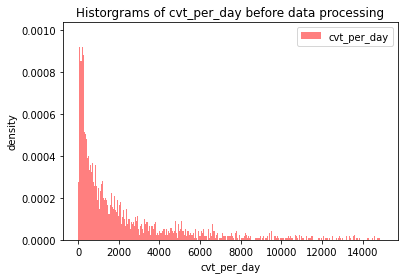

In [ ]:
plt.hist(TV['cvt_per_day'],bins=range(0,15000,30),color='r',label='cvt_per_day',density=True,alpha=0.5)
plt.title('Historgrams of cvt_per_day before data processing')
plt.legend(loc='upper right')
plt.xlabel('cvt_per_day')
plt.ylabel('density')
plt.show()

### 2.2.3 Correlation among numerical features

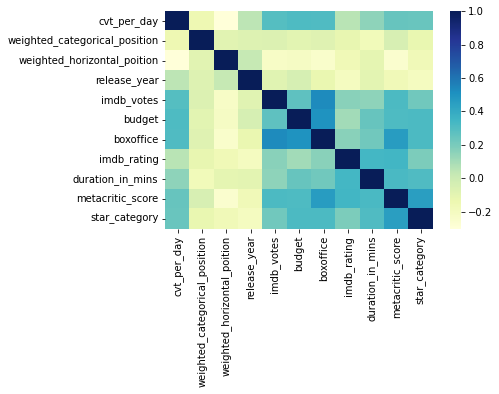

In [ ]:
corr = TV[['cvt_per_day','weighted_categorical_position','weighted_horizontal_poition'
               ,'release_year', 'imdb_votes', 'budget', 'boxoffice' ,'imdb_rating', 
               'duration_in_mins', 'metacritic_score', 'star_category']].corr()

sns.heatmap(corr, cmap="YlGnBu")

In [ ]:
corr

,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,release_year,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,star_category
cvt_per_day,1.000,-0.148,-0.302,0.046,0.298,0.316,0.312,0.059,0.152,0.249,0.247
weighted_categorical_position,-0.148,1.000,-0.084,-0.069,-0.064,-0.090,-0.074,-0.116,-0.174,-0.044,-0.123
weighted_horizontal_poition,-0.302,-0.084,1.000,0.027,-0.221,-0.211,-0.245,-0.162,-0.102,-0.255,-0.168
release_year,0.046,-0.069,0.027,1.000,-0.083,-0.040,-0.128,-0.199,-0.097,-0.167,-0.198
imdb_votes,0.298,-0.064,-0.221,-0.083,1.000,0.273,0.531,0.163,0.156,0.322,0.225
budget,0.316,-0.090,-0.211,-0.040,0.273,1.000,0.505,0.106,0.251,0.315,0.322
boxoffice,0.312,-0.074,-0.245,-0.128,0.531,0.505,1.000,0.164,0.226,0.465,0.322
imdb_rating,0.059,-0.116,-0.162,-0.199,0.163,0.106,0.164,1.000,0.344,0.347,0.192
duration_in_mins,0.152,-0.174,-0.102,-0.097,0.156,0.251,0.226,0.344,1.000,0.327,0.309
metacritic_score,0.249,-0.044,-0.255,-0.167,0.322,0.315,0.465,0.347,0.327,1.000,0.452


## 2.3 Understand categorical features

### 2.3.1 Distribution of standard categorical features

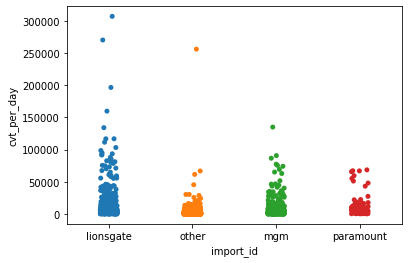

other        2963
lionsgate     677
mgm           445
paramount     141
Name: import_id, dtype: int64


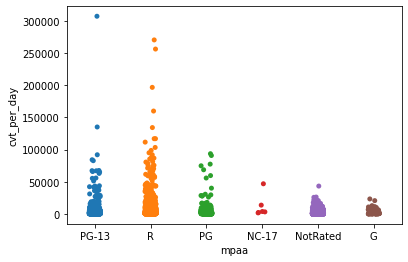

NotRated    2158
R           1158
PG-13        426
PG           353
G            125
NC-17          6
Name: mpaa, dtype: int64


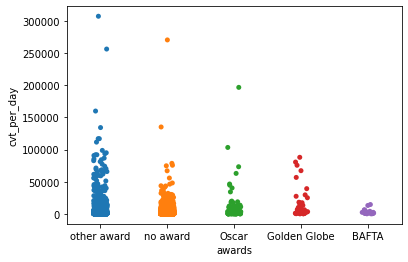

no award        2569
other award     1453
Oscar            141
Golden Globe      44
BAFTA             19
Name: awards, dtype: int64


In [ ]:
sns.stripplot(x='import_id', y='cvt_per_day', data=TV,jitter=True)
plt.show()
print(TV['import_id'].value_counts())

sns.stripplot(x='mpaa', y='cvt_per_day', data=TV,jitter=True)
plt.show()
print(TV['mpaa'].value_counts())

sns.stripplot(x='awards', y='cvt_per_day', data=TV, jitter=True)
plt.show()
print(TV['awards'].value_counts())

### 2.3.2 Distribution of splited genres

Some videos belongs to more than 1 genre, the genre of each video is splited, this would help emphasize the effect of each individual genre.

Action                    739
Adult                       3
Adventure                 363
Animation                 129
Anime                      11
Comedy                   1184
Crime                     437
Documentary               671
Drama                    1677
Fantasy                   243
Foreign/International      64
Holiday                     1
Horror                    762
Independent               393
Kids & Family             280
LGBT                        2
Lifestyle                   7
Music                     171
Musicals                   68
Mystery                   375
Reality                     9
Romance                   591
Sci-Fi                    363
Sport                      77
Thriller                  879
War                       102
Western                   102
dtype: int64


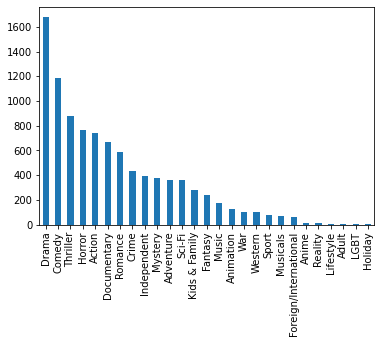

In [ ]:
# generes explore, split the genre of each video
gen_split = TV['genres'].str.get_dummies(sep=',').sum()
print(gen_split)

gen_split.sort_values(ascending=False).plot.bar()

### 2.3.3 Distribution of release_year

The release year of video varies through a wide range. Considering the popularity of a video usually decays over time, the release_year should be bucketed based on the release_year range.

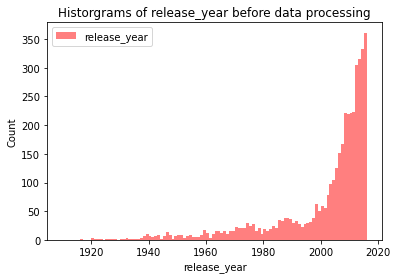

In [ ]:
plt.hist(TV['release_year'].values, bins = range(1910, 2017, 1), alpha = 0.5, color='r', label = 'release_year')
plt.legend(loc ='upper left')
plt.title('Historgrams of release_year before data processing')
plt.xlabel('release_year')
plt.ylabel('Count')
plt.show()


# Part 3: Feature Preprocessing

## 3.1 Categorical features

There are 5 categorical features: import_id, mpaa, awards, genres, and release_year. There is no missing data in them. They can be converted into dummy/indicators.

The first 3 have relatively small sub-types, they can be easily converted to dummies.

The 'genres' have 27 different sub-types, 6 of them are rarely observed (refer to previous section). It's reasonable to group these 6 into 1


In [ ]:
# Convert 3 Categorical variables into dummy variables
d_import_id = pd.get_dummies(TV['import_id']).astype(np.int64)
d_mpaa = pd.get_dummies(TV['mpaa']).astype(np.int64)
d_awards = pd.get_dummies(TV['awards']).astype(np.int64)

In [ ]:
# Convert 'genres' into dummy variables
d_genres=TV['genres'].str.get_dummies(sep=',').astype(np.int64)
d_genres['Misc_genres']=d_genres['Anime']|d_genres['Reality']|d_genres['Lifestyle']|d_genres['Adult']|d_genres['LGBT']|d_genres['Holiday']
d_genres.drop(['Anime', 'Reality','Lifestyle', 'Adult','LGBT','Holiday'], inplace=True, axis=1)

In [ ]:
TV['release_year'].quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

0.100   1974.000
0.200   1991.000
0.300   2001.000
0.400   2006.000
0.500   2008.000
0.600   2010.000
0.700   2012.000
0.800   2013.000
0.900   2014.000
Name: release_year, dtype: float64

In [ ]:
# bin release_year and convert into dummies(Divide the release_data into 10 bins, and each bin contains 10% data)
bin_year = [1916, 1974, 1991, 2001, 2006, 2008, 2010, 2012, 2013, 2014, 2017]
year_range = ['1916-1974', '1974-1991', '1991-2001', '2001-2006','2006-2008','2008-2010','2010-2012','2012-2013',
              '2013-2014','2014-2017']

year_bin = pd.cut(TV['release_year'], bin_year, labels=year_range)
d_year = pd.get_dummies(year_bin).astype(np.int64)

In [ ]:
# new dataframe, drop the previous categorical features, add new dummy variables, check for null

temp_tv=TV.drop(['import_id', 'mpaa','awards','genres', 'release_year'], axis=1)

newTV = pd.concat([temp_tv, d_import_id, d_mpaa, d_awards, d_genres, d_year], axis=1)
print(newTV.head())

   video_id  cvt_per_day  weighted_categorical_position  \
0    385504   307127.606                              1   
1    300175   270338.426                              1   
2    361899   256165.867                              1   
3    308314   196622.721                              3   
4    307201   159841.652                              1   

   weighted_horizontal_poition  imdb_votes    budget  boxoffice  imdb_rating  \
0                            3       69614  15000000   42930462        6.500   
1                            3       46705  15000000    3301046        6.500   
2                            3      197596  26000000   37397291        7.300   
3                            4      356339  15000000   15700000        7.600   
4                            3       46720  27220000    8551228        6.400   

   duration_in_mins  metacritic_score  star_category  lionsgate  mgm  other  \
0           112.301                51          1.710          1    0      0   
1     

## 3.2 Missing data

Among the 10 numerical features (not include video_id), 4 features have over 25% of missing values (shown as '0'): budget, boxoffice, metacritic_score, star_category. 2 features have less than 10% of missing data: imdb_votes, imdb_rating.

There are 3242 samples have at least one missing data.

Deal with the missing data: According to the data info, there is no Null value in the dataset.
But the zero value can be a potential candidate for missing data. 
So it is necssary to check the ratio of zero value in our numeric feature

In [ ]:
newTV[['budget','boxoffice','metacritic_score', 'star_category','imdb_votes', 'imdb_rating']] = newTV[['budget','boxoffice','metacritic_score', 'star_category','imdb_votes', 'imdb_rating']].replace(0, np.nan)
print(newTV.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4226 entries, 0 to 4225
Data columns (total 58 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   video_id                       4226 non-null   int64  
 1   cvt_per_day                    4226 non-null   float64
 2   weighted_categorical_position  4226 non-null   int64  
 3   weighted_horizontal_poition    4226 non-null   int64  
 4   imdb_votes                     3882 non-null   float64
 5   budget                         1772 non-null   float64
 6   boxoffice                      1032 non-null   float64
 7   imdb_rating                    3882 non-null   float64
 8   duration_in_mins               4226 non-null   float64
 9   metacritic_score               1214 non-null   float64
 10  star_category                  2380 non-null   float64
 11  lionsgate                      4226 non-null   int64  
 12  mgm                            4226 non-null   i

Filling missing data with mean value（I tried filling the missing value with the median and the mean and found that filling with the mean was better）

In [ ]:
newTV1=newTV.copy()
newTV1['boxoffice']=newTV1['boxoffice'].fillna(newTV1['boxoffice'].mean())
newTV1['metacritic_score']=newTV1['metacritic_score'].fillna(newTV1['metacritic_score'].mean())
newTV1['star_category']=newTV1['star_category'].fillna(newTV1['star_category'].mean())
newTV1['imdb_votes']=newTV1['imdb_votes'].fillna(newTV1['imdb_votes'].mean())
newTV1['imdb_rating']=newTV1['imdb_rating'].fillna(newTV1['imdb_rating'].mean())
newTV1['budget']=newTV1['budget'].fillna(newTV1['budget'].mean())
print(newTV1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4226 entries, 0 to 4225
Data columns (total 58 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   video_id                       4226 non-null   int64  
 1   cvt_per_day                    4226 non-null   float64
 2   weighted_categorical_position  4226 non-null   int64  
 3   weighted_horizontal_poition    4226 non-null   int64  
 4   imdb_votes                     4226 non-null   float64
 5   budget                         4226 non-null   float64
 6   boxoffice                      4226 non-null   float64
 7   imdb_rating                    4226 non-null   float64
 8   duration_in_mins               4226 non-null   float64
 9   metacritic_score               4226 non-null   float64
 10  star_category                  4226 non-null   float64
 11  lionsgate                      4226 non-null   int64  
 12  mgm                            4226 non-null   i

## 3.3 Feature scaling

The impact of different scaling methods on the model performance is small. In the following model training and selections, the standard scaling (sc) data is used.

In [ ]:
# Standardization
 
scale_lst = ['weighted_categorical_position', 'weighted_horizontal_poition', 'budget','boxoffice', 
             'imdb_votes','imdb_rating','duration_in_mins', 'metacritic_score','star_category']
newTV_sc = newTV1.copy() 
sc_scale = preprocessing.StandardScaler().fit(newTV_sc[scale_lst])
newTV_sc[scale_lst] = sc_scale.transform(newTV_sc[scale_lst])
newTV_sc.head()


,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,star_category,lionsgate,mgm,other,paramount,G,NC-17,NotRated,PG,PG-13,R,BAFTA,Golden Globe,Oscar,no award,other award,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Fantasy,Foreign/International,Horror,Independent,Kids & Family,Music,Musicals,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,Misc_genres,1916-1974,1974-1991,1991-2001,2001-2006,2006-2008,2008-2010,2010-2012,2012-2013,2013-2014,2014-2017
0,385504,307127.606,-1.106,-2.116,1.984,1.470,4.696,0.542,1.079,-0.630,0.033,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,300175,270338.426,-1.106,-2.116,1.258,1.470,-1.022,0.542,0.257,-1.997,3.434,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,361899,256165.867,-1.106,-2.116,6.043,3.108,3.898,1.100,1.243,0.327,2.102,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,308314,196622.721,-0.780,-2.032,11.077,1.470,0.767,1.309,1.952,5.250,-0.063,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0
4,307201,159841.652,-1.106,-2.116,1.258,3.290,-0.265,0.472,0.758,-2.544,3.029,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


# Part 4: Model Training

In [ ]:
train, test = train_test_split(newTV_sc, test_size=0.15, random_state = 3)
model_train_x = train.drop(['video_id', 'cvt_per_day'], axis = 1)
model_test_x = test.drop(['video_id', 'cvt_per_day'], axis = 1)
model_train_y = train['cvt_per_day']
model_test_y = test['cvt_per_day']

### 4.1 Lasso linear regression

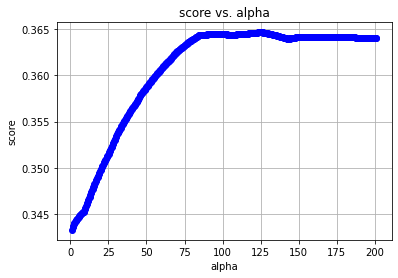

The optimaized alpha and score of Lasso linear is: 


(None, 125.64929859719439, 0.3646194368519905)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score #not used
from math import sqrt

lr_train, lr_validate = train_test_split(train, test_size=0.15, random_state = 0)

lr_train_x = lr_train.drop(['video_id', 'cvt_per_day'], axis = 1)
lr_validate_x = lr_validate.drop(['video_id', 'cvt_per_day'], axis = 1)
lr_train_y = lr_train['cvt_per_day']
lr_validate_y = lr_validate['cvt_per_day']

alphas = np.linspace (1, 201, num=500)
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    lasso = Lasso()
    lasso.set_params(alpha = a)
    lasso.fit(lr_train_x, lr_train_y)
    scores[i] = lasso.score(lr_validate_x, lr_validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        lasso_save = lasso #optional code
plt.plot(alphas, scores, color='b', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
model1_para = opt_a
print ('The optimaized alpha and score of Lasso linear is: '), opt_a, max_score


In [ ]:
# combine the validate data and training data, use the optimal alpha, re-train the model
lasso_f = Lasso()
lasso_f.set_params(alpha = opt_a)
lasso_f.fit(model_train_x, model_train_y)


Lasso(alpha=125.64929859719439)

## 4.2 Ridge linear regression

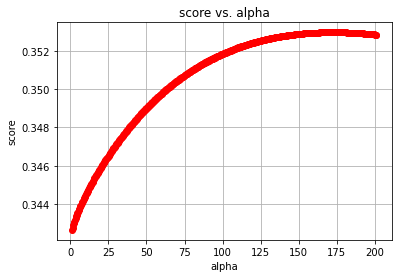

The optimaized alpha and score of Ridge linear is: 


(None, 172.5430861723447, 0.3529726994066543)

In [ ]:
# Use the same training data set as Lasso (linear features)
lr_train, lr_validate = train_test_split(train, test_size=0.15, random_state = 0)

alphas = np.linspace (1, 201, num=500)
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    ridge = Ridge()
    ridge.set_params(alpha = a)
    ridge.fit(lr_train_x, lr_train_y)
    scores[i] = ridge.score(lr_validate_x, lr_validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        ridge_save = ridge #optional code
plt.plot(alphas, scores, color='r', linestyle='dashed', marker='o',markerfacecolor='r', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
model3_para = opt_a
print ('The optimaized alpha and score of Ridge linear is: '), opt_a, max_score

In [ ]:
# add the 15% validate data, use the optimal alpha, re-train the model

ridge_f = Ridge()
ridge_f.set_params(alpha = opt_a)
ridge_f.fit(model_train_x, model_train_y)

# ridge_f is the Ridge model (linear feature), to be tested with test data.

Ridge(alpha=172.5430861723447)

##4.3 Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf=RandomForestRegressor(random_state=2,max_features='sqrt')
param_grid={'n_estimators':[55,56,57,58,59,60,61,62,63,64,65],'max_depth':[15,16,17,18,19,20,21]}
clf=GridSearchCV(estimator=rf,param_grid=param_grid,cv=5)
clf.fit(model_train_x,model_train_y)

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_features='sqrt',
                                             random_state=2),
             param_grid={'max_depth': [15, 16, 17, 18, 19, 20, 21],
                         'n_estimators': [55, 56, 57, 58, 59, 60, 61, 62, 63,
                                          64, 65]})

{'mean_fit_time': array([0.30167832, 0.62453828, 0.61054831, 0.37640924, 0.26669641,
       0.27802601, 0.27496281, 0.28138204, 0.28211651, 0.28843026,
       0.2922102 , 0.2558187 , 0.26266632, 0.27306895, 0.2777699 ,
       0.28121033, 0.28931613, 0.29304266, 0.29420271, 0.29914498,
       0.30637875, 0.30951638, 0.27605381, 0.27932801, 0.28424096,
       0.28602829, 0.29518204, 0.29745078, 0.30042644, 0.30525174,
       0.30820274, 0.31390309, 0.319034  , 0.28096809, 0.28109612,
       0.29235921, 0.29824429, 0.30507746, 0.31241961, 0.30837536,
       0.31880932, 0.32351174, 0.32605238, 0.32775154, 0.28843207,
       0.29436526, 0.29861083, 0.30649781, 0.31178637, 0.31716604,
       0.3191741 , 0.33196259, 0.33340225, 0.33329396, 0.34036388,
       0.29499407, 0.30013804, 0.30264482, 0.30826836, 0.31609654,
       0.32218423, 0.3228724 , 0.3319973 , 0.33788986, 0.47887664,
       0.34244976, 0.3006424 , 0.30969419, 0.31146002, 0.32129459,
       0.32343359, 0.33586235, 0.33336825, 0

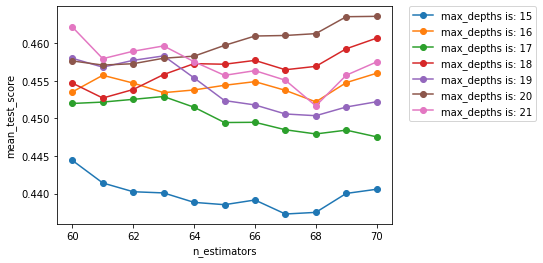

the best parameter for max_depth is: 20
the best parameter for n_estimators is: 65


In [ ]:
result=clf.cv_results_
print(result)
max_depth=[15,16,17,18,19,20,21]   
n_estimators=[60,61,62,63,64,65,66,67,68,69,70]   
scores=clf.cv_results_['mean_test_score'].reshape(len(max_depth),len(n_estimators))
plt.figure(1)
plt.subplot(1,1,1)
for i,j in enumerate(max_depth):
  plt.plot(n_estimators,scores[i],'-o',label='max_depths is: '+str(j))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('n_estimators')
plt.ylabel('mean_test_score')
plt.show()
print('the best parameter for max_depth is: '+str(clf.best_params_['max_depth']))
print('the best parameter for n_estimators is: '+str(clf.best_params_['n_estimators']))



# Part 5: Model Evaluation

## 5.1: Evaluate all models

In [ ]:
train_x = model_train_x
train_y = model_train_y
test_x = model_test_x
test_y = model_test_y

In [ ]:
#For lasso
from sklearn.linear_model import Lasso
from sklearn.metrics import  mean_squared_error
lasso=Lasso(alpha=model1_para)
lasso.fit(train_x,train_y)
pred_y=lasso.predict(test_x)
lasso_score=lasso.score(test_x,test_y)
MSE_lasso=mean_squared_error(test_y,pred_y)
RMSE_lasso=np.sqrt(MSE_lasso)
print ('lasso score: ', lasso_score)
print ('Mean square error of lasso: ', MSE_lasso)
print ('Root mean squared error of lasso:', RMSE_lasso)

lasso score:  0.09898048413763116
Mean square error of lasso:  239104131.54554778
Root mean squared error of lasso: 15462.99232184857


In [ ]:
#for ridge
from sklearn.metrics import  mean_squared_error
ridge=Ridge(alpha=model3_para)
ridge.fit(train_x,train_y)
pred_y=ridge.predict(test_x)
ridge_score=ridge.score(test_x,test_y)
MSE_ridge=mean_squared_error(test_y,pred_y)
RMSE_ridge=np.sqrt(MSE_ridge)
print ('ridge score: ', ridge_score)
print ('Mean square error of ridge: ', MSE_ridge)
print ('Root mean squared error of ridge:', RMSE_ridge)

ridge score:  0.1138238752321652
Mean square error of ridge:  235165131.2526933
Root mean squared error of ridge: 15335.094758516925


In [ ]:
#For randomforest regression
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators=clf.best_params_['n_estimators'],max_depth=clf.best_params_['max_depth'],max_features='sqrt',random_state=2,n_jobs=-1)
rf.fit(train_x,train_y)
pred_y=rf.predict(test_x)
rf_score=rf.score(test_x,test_y)
MSE_rf=mean_squared_error(test_y,pred_y)
RMSE_rf=np.sqrt(MSE_rf)
print ('rf score: ', rf_score)
print ('Mean square error of rf: ', MSE_rf)
print ('Root mean squared error of rf:', RMSE_rf)


rf score:  0.5169719005665712
Mean square error of rf:  128181479.08437566
Root mean squared error of rf: 11321.725976386095


## 5.2 Model comparison 

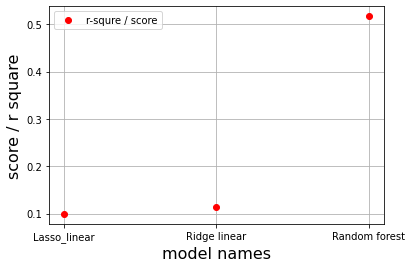

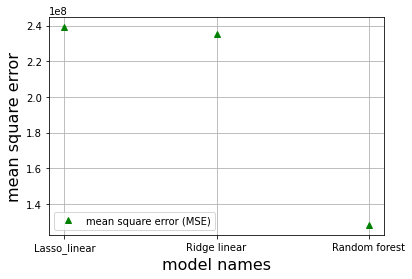

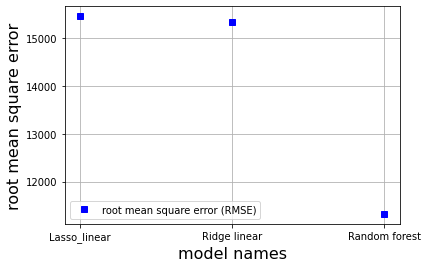

In [ ]:
lst_score = [lasso_score, ridge_score, rf_score]
MSE_lst =  [MSE_lasso, MSE_ridge, MSE_rf]
RMSE_lst =  [RMSE_lasso, RMSE_ridge, RMSE_rf]
model_lst = ['Lasso_linear', 'Ridge linear', 'Random forest']

plt.figure(1)
plt.plot(model_lst, lst_score, 'ro')
plt.legend(['r-squre / score'])
plt.xlabel('model names',fontsize =16)
plt.ylabel('score / r square', fontsize =16)
plt.grid(True)
plt.show()

plt.figure(2)
plt.plot(model_lst, MSE_lst, 'g^')
plt.legend(['mean square error (MSE)'])
plt.xlabel('model names', fontsize =16)
plt.ylabel('mean square error', fontsize =16)
plt.grid(True)
plt.show()

plt.figure(3)
plt.plot(model_lst, RMSE_lst, 'bs')
plt.legend(['root mean square error (RMSE)'])
plt.xlabel('model names', fontsize =16)
plt.ylabel('root mean square error', fontsize =16)
plt.grid(True)
plt.show()

## 5.3 Feature importance

According to MSE,RMSE and R square, the Random Forest Regression has the best performance

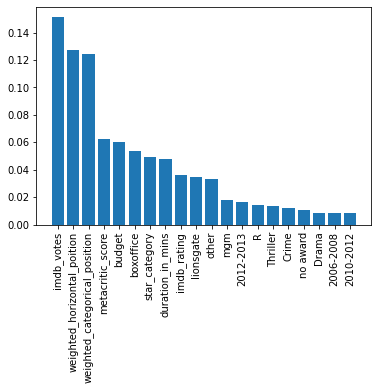

In [ ]:
importances = rf.feature_importances_
feature_name = train_x.columns.values
indices = np.argsort(importances)[::-1]
plt.figure(1)
plt.bar(feature_name[indices[:20]], importances[indices[:20]])
plt.xticks(rotation=90)
plt.show()